In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [44]:
import csv
import cv2
import random

lines = []
steering_angles = []

with open("./data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # ignore first line which contains the headers
    for line in reader:
        steering_angle = float(line[3])
        if abs(steering_angle) > 0.085 or random.random() > 0.85:
            steering_angles.append(steering_angle)
            lines.append(line)

from sklearn.model_selection import train_test_split
train_lines, validation_lines = train_test_split(lines, test_size=0.2)
print(len(lines)/8036)
#print(len(train_lines))
#print(len(validation_lines))

0.4057989049278248


<a list of 30 Patch objects>

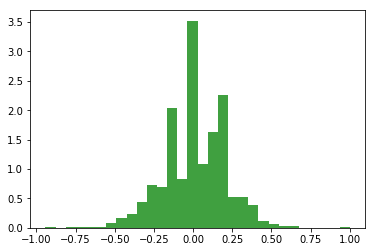

In [45]:
plt.hist(np.array(steering_angles), 30, normed=1, facecolor='green', alpha=0.75) [2]

In [ ]:

        
images, measurements = [], []

for line in lines:
#     source_path = "./data/" + line[0]
#     image = cv2.imread(source_path)
#     images.append(image)
#     measurement = float(line[3])
#     measurements.append(measurement)
    
    for i in range(3): # go through 3 camera angles
        source_path = "./data/" + line[i]
        image = cv2.imread(source_path)
        images.append(image)
        # Add steering angle adjustment to left/right cameras
        if (i==0): # center camera
            measurement = float(line[3]) 
        elif (i==1): # left camera
            measurement = float(line[3]) + 0.2
        elif (i==2): # right camera
            measurement = float(line[3]) - 0.2
        measurements.append(measurement)

augmented_images, augmented_measurements = [], []
for image, measuremement in zip(images,measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    flipped_image = cv2.flip(image, 1)
    augmented_images.append(flipped_image)
    augmented_measurements.append(measurement * -1.0)
    
X_data = np.array(images + augmented_images)
y_data = np.array(measurements + augmented_measurements)

np.save("./data/X_data.npy", X_data)
np.save("./data/y_data.npy", y_data)

In [46]:
import random

def get_augmented_row(line):
    angle_idx = random.randint(0, 2)
    source_path = "./data/" + line[angle_idx].strip()
    image = cv2.imread(source_path)
    steering_angle = float(line[3])
    
    # Add steering angle adjustment to left/right cameras
    if (angle_idx == 0): # center camera
        steering_angle_corrected = steering_angle
    elif (angle_idx == 1): # left camera
        steering_angle_corrected = steering_angle + 0.1
    elif (angle_idx == 2): # right camera
        steering_angle_corrected = steering_angle - 0.1
    
    flipped = random.randint(0, 1) == 0
    if flipped:
        steering_angle_corrected *= -1
        image = np.fliplr(image)
        
    return image.astype(np.float32), steering_angle_corrected
    
    
def get_data_generator(csv_data, batch_size=32):
    nr_rows_in_csv_data = len(csv_data)

    batches_per_epoch = nr_rows_in_csv_data // batch_size
    batch_nr = 0

    while(True):
        start_idx = batch_nr * batch_size
        end_idx = start_idx + batch_size - 1
        #print(start_idx, end_idx, csv_data[start_idx:(end_idx+1)])

        # initialize your batch data
        X_batch = np.zeros((batch_size, 160, 320, 3), dtype=np.float32)
        y_batch = np.zeros((batch_size,), dtype=np.float32)

        # slice a `batch_size` sized chunk from the csv_data
        # and generate augmented data for each row in the chunk on the fly
        for idx, csv_line in enumerate(csv_data[start_idx:(end_idx+1)]):
            # perform image augmentation for each row
            X, y = get_augmented_row(csv_line)
            X_batch[idx], y_batch[idx] = X, y

        batch_nr += 1
        if batch_nr == batches_per_epoch - 1:
            # reset the index so that we can cycle over the csv_data again
            batch_nr = 0
        yield X_batch, y_batch

In [ ]:
from keras.models import Sequential 
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Dropout

batch_size = 32

train_generator = get_data_generator(train_lines, batch_size=batch_size)
validation_generator = get_data_generator(validation_lines, batch_size=batch_size)

model = Sequential()
model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: x / 255.0 - 0.5))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation="elu"))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation="elu"))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation="elu"))
model.add(Convolution2D(64, 3, 3, activation="elu"))
model.add(Convolution2D(64, 3, 3, activation="elu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(p=0.5))
model.add(Dense(50))
model.add(Dropout(p=0.5))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#model.fit(X_data, y_data, validation_split=0.2, shuffle=True, nb_epoch=4)
history_object = model.fit_generator(train_generator,
                                     samples_per_epoch=(len(train_lines) // batch_size) * batch_size,
                                     validation_data=validation_generator,
                                     nb_val_samples=(len(validation_lines) // batch_size) * batch_size,
                                     nb_epoch=8,
                                     verbose=1)

model.save('model.h5')

Epoch 1/8
2592/2592 [==============================] - 32s - loss: 0.0757 - val_loss: 0.0315

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

* Image pre-processing:
  * RGB conversion after reading images, fixed that (!)
  * BGR2RGB conversion (since I'm importing images with cv2)
  * YUV color spaces instead of RGB
  * Try shadow and brightness augmentation
  * Cropping top 70, bottom 25 px using Cropping2D in keras (per video)

* Data augmenting/filtering
  * Exclude something like 70% of the images with abs(sterring_angles) <= 0.85.
  * Using left, right, and center images (with +/- 0.2 steering adjustment for left/right)
  * flipping all 3 of them and *-1.0 steering angle (total of 6 images per .xls line item)

* Model architecture
  * Use NVIDIA architecture
  * Changed the dropout layer location: 2 dropout layers after fully connected layers begin
  * change RELU to ELU. Changed initial weights (kernel_initializer) to he_normal from default

* Training
 * train model with large data first (6-7 epochs) and retrained with smaller datasets in problem areas with 1/10th learning rate.